In [30]:
# Load Libraries
import pandas as pd
import string
import spacy
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from itertools import combinations
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency

In [31]:
# Load the data from the CSV files
overall_paragraphs = pd.read_csv('/Users/dgkamper/DGK_Lab/Collaborations/Intellectual Humility/middlepeople/Dataset/OverallParagraphs.csv')

# Check Upload
(overall_paragraphs.head())

,ID,Paragraph
0,1,Defunding the police is important to me becaus...
1,2,I am pro choice. A person with a uterus’ body ...
2,4,Standardized testing is important. It helps pr...
3,5,I chose the legalization of abortion. I fully ...
4,6,I personally believe that people should be vac...


In [32]:
def basic_clean_text(text):
    # Tokenize text by splitting on whitespace
    tokens = text.split()
    # Convert to lower case
    tokens = [word.lower() for word in tokens]
    # Remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]
    # Remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    return words

# Apply the basic cleaning function to the Paragraph column
overall_paragraphs['basic_cleaned_text'] = overall_paragraphs['Paragraph'].apply(basic_clean_text)

# Show the basic cleaned text
overall_paragraphs[['Paragraph', 'basic_cleaned_text']].head()


,Paragraph,basic_cleaned_text
0,Defunding the police is important to me becaus...,"[defunding, the, police, is, important, to, me..."
1,I am pro choice. A person with a uterus’ body ...,"[i, am, pro, choice, a, person, with, a, body,..."
2,Standardized testing is important. It helps pr...,"[standardized, testing, is, important, it, hel..."
3,I chose the legalization of abortion. I fully ...,"[i, chose, the, legalization, of, abortion, i,..."
4,I personally believe that people should be vac...,"[i, personally, believe, that, people, should,..."


In [33]:
def count_syllables(word):
    # Count the number of syllables in a word.
    word = word.lower()
    syllable_count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        syllable_count += 1
    for i in range(1, len(word)):
        if word[i] in vowels and word[i - 1] not in vowels:
            syllable_count += 1
    if word.endswith("e"):
        syllable_count -= 1
    if syllable_count == 0:
        syllable_count = 1
    return syllable_count

def calculate_ttr_fkg(text_list):
    # Type-Token Ratio
    types = set(text_list)
    tokens = len(text_list)
    ttr = len(types) / tokens if tokens > 0 else 0
    
    # Flesch-Kincaid Grade Level
    sentences = re.split(r'[.!?]+', ' '.join(text_list))
    sentence_count = max(1, len(sentences))
    word_count = len(text_list)
    syllable_count = sum(count_syllables(word) for word in text_list)
    
    avg_sentence_length = word_count / sentence_count
    avg_syllables_per_word = syllable_count / word_count if word_count > 0 else 0
    
    fk_grade = 0.39 * avg_sentence_length + 11.8 * avg_syllables_per_word - 15.59
    
    return ttr, fk_grade

# Apply TTR and FKG calculation
overall_paragraphs['TTR'], overall_paragraphs['FK_Grade'] = zip(*overall_paragraphs['basic_cleaned_text'].map(calculate_ttr_fkg))

# Show the calculated metrics
overall_paragraphs[['Paragraph', 'TTR', 'FK_Grade']].head()

,Paragraph,TTR,FK_Grade
0,Defunding the police is important to me becaus...,0.675000,34.932500
1,I am pro choice. A person with a uterus’ body ...,0.780000,20.430000
2,Standardized testing is important. It helps pr...,0.750000,36.274762
3,I chose the legalization of abortion. I fully ...,0.733333,30.966667
4,I personally believe that people should be vac...,0.921053,18.482632


In [34]:
# Keywords dictionary for topic classification
keywords = {
    'Vaccines': ["vaccine", "vaccines", "vaccinated", "vaccination", "immunization"],
    'Abortion': ["abortion", "pro-choice", "pro-life", "reproductive rights", "pregnancy", "births"],
    'Police': ["police", "defund", "law enforcement", "policing"],
    'Drugs': ["drugs", "drug", "psychedelics", "opiates", "weed", "marijuana", "barbiturates", "legalization", "addiction"],
    'AffirmativeAction': ["affirmative action", "diversity", "quotas", "equal opportunity"],
    'StandardizedTests': ["standardized tests", "standardized testing", "standard tests", "SAT", "ACT", "admissions", "college administrators"]
}

# Function to classify paragraphs based on keywords
def classify_paragraph(paragraph, keywords):
    for topic, keyword_list in keywords.items():
        if any(re.search(r'\b' + re.escape(keyword) + r'\b', paragraph, re.IGNORECASE) for keyword in keyword_list):
            return topic
    return "Other"

# Apply the classification to each paragraph in the data
overall_paragraphs['Topic'] = overall_paragraphs['Paragraph'].apply(classify_paragraph, args=(keywords,))

# Display first few rows of the data
overall_paragraphs[['Paragraph', 'Topic', 'TTR', 'FK_Grade']].head()

,Paragraph,Topic,TTR,FK_Grade
0,Defunding the police is important to me becaus...,Police,0.675000,34.932500
1,I am pro choice. A person with a uterus’ body ...,Abortion,0.780000,20.430000
2,Standardized testing is important. It helps pr...,StandardizedTests,0.750000,36.274762
3,I chose the legalization of abortion. I fully ...,Abortion,0.733333,30.966667
4,I personally believe that people should be vac...,Vaccines,0.921053,18.482632


In [35]:
# Get Averages
average_scores = overall_paragraphs.groupby('Topic')[['TTR', 'FK_Grade']].mean()

# Reset the index to make 'Topic' a column
average_scores.reset_index(inplace=True)

# Display the average scores by topic
print(average_scores)

# Calculate mean, standard deviation, and count for each group
grouped = overall_paragraphs.groupby('Topic')[['TTR', 'FK_Grade']].agg(['mean', 'std', 'count'])

# Calculate the standard error for TTR and FK_Grade
grouped['TTR_SE'] = grouped[('TTR', 'std')] / np.sqrt(grouped[('TTR', 'count')])
grouped['FK_Grade_SE'] = grouped[('FK_Grade', 'std')] / np.sqrt(grouped[('FK_Grade', 'count')])

# Simplify the DataFrame by dropping multi-level columns if desired
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

print(grouped.columns)

               Topic       TTR   FK_Grade
0           Abortion  0.725278  38.613429
1  AffirmativeAction  0.773297  35.935627
2              Drugs  0.762254  32.885487
3              Other  0.794460  18.373650
4             Police  0.753787  33.589395
5  StandardizedTests  0.738080  36.938457
6           Vaccines  0.788805  31.607475
Index(['TTR_mean', 'TTR_std', 'TTR_count', 'FK_Grade_mean', 'FK_Grade_std',
       'FK_Grade_count', 'TTR_SE_', 'FK_Grade_SE_'],
      dtype='object')


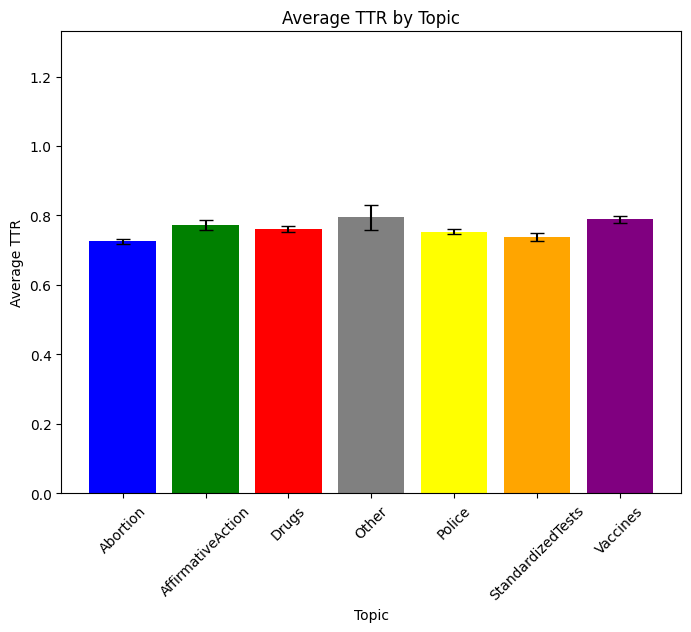

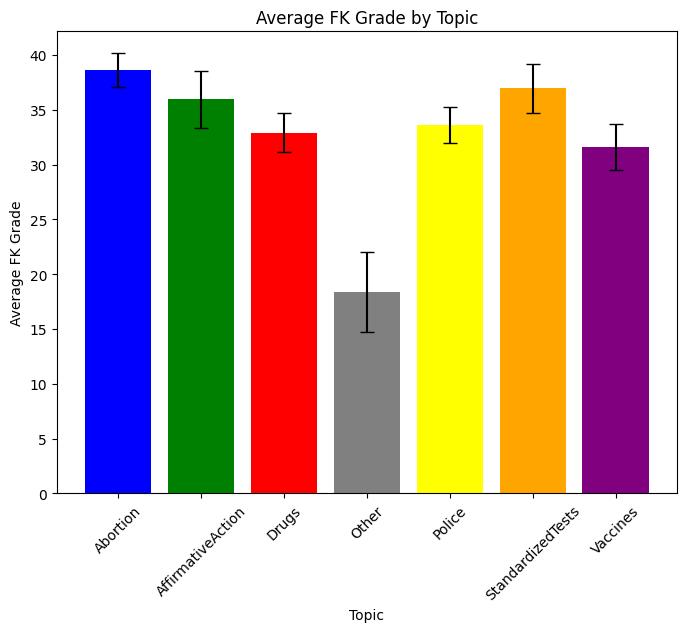

In [37]:
# DataFrame with 'Topic', 'TTR_mean', 'TTR_SE', 'FK_Grade_mean', 'FK_Grade_SE'
topics = ['Abortion', 'AffirmativeAction', 'Drugs', 'Other', 'Police', 'StandardizedTests', 'Vaccines']
means_ttr = grouped['TTR_mean']
se_ttr = grouped['TTR_SE_']
means_fk = grouped['FK_Grade_mean']
se_fk = grouped['FK_Grade_SE_']

colors = ['blue', 'green', 'red', 'gray', 'yellow','orange', 'purple']

# Plot for TTR
plt.figure(figsize=(8, 6))
plt.bar(topics, means_ttr, yerr=se_ttr, color=colors, capsize=5)
plt.title('Average TTR by Topic')
plt.xlabel('Topic')
plt.ylabel('Average TTR')
plt.xticks(rotation=45)
plt.ylim(0, max(means_ttr + se_ttr) + 0.5)  # Adjust ylim to accommodate error bars
plt.grid(False)
plt.show()

# Plot for FK_Grade
plt.figure(figsize=(8, 6))
plt.bar(topics, means_fk, yerr=se_fk, color=colors, capsize=5)
plt.title('Average FK Grade by Topic')
plt.xlabel('Topic')
plt.ylabel('Average FK Grade')
plt.xticks(rotation=45)
plt.ylim(0, max(means_fk + se_fk) + 2)  # Adjust ylim to accommodate error bars
plt.grid(False)
plt.show()


In [21]:
# Apply classification function
overall_paragraphs['Topic'] = overall_paragraphs['Paragraph'].apply(classify_paragraph, args=(keywords,))

# Count the number of paragraphs per topic
topic_counts = overall_paragraphs['Topic'].value_counts().reset_index()
topic_counts.columns = ['Topic', 'Count']
print(topic_counts)

               Topic  Count
0           Abortion    262
1             Police    139
2              Drugs    129
3           Vaccines    111
4  AffirmativeAction     68
5  StandardizedTests     63
6              Other     27


In [38]:
import spacy
from spacy.matcher import Matcher

# Load the English NLP model
nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

# Define patterns for claims and premises
claim_pattern = [{"LOWER": "claim"}]
premise_pattern = [{"LOWER": "because"}]

matcher.add("CLAIM", [claim_pattern])
matcher.add("PREMISE", [premise_pattern])

# Function to apply argumentation mining
def analyze_arguments(text):
    doc = nlp(text)
    matches = matcher(doc)
    arguments = {'claims': [], 'premises': []}
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]
        if string_id == 'CLAIM':
            arguments['claims'].append(doc[start:end].text)
        elif string_id == 'PREMISE':
            arguments['premises'].append(doc[start:end].text)
    return arguments

# Apply the function to each paragraph and extract arguments
overall_paragraphs['Arguments'] = overall_paragraphs['Paragraph'].apply(analyze_arguments)
print(overall_paragraphs[['Topic', 'Arguments']].head())


               Topic                                Arguments
0             Police  {'claims': [], 'premises': ['because']}
1           Abortion           {'claims': [], 'premises': []}
2  StandardizedTests           {'claims': [], 'premises': []}
3           Abortion           {'claims': [], 'premises': []}
4           Vaccines           {'claims': [], 'premises': []}
